In [3]:
import vtracer
from PIL import Image

import io

import cairosvg
import cv2
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, ImageFilter


In [95]:
input = "/home/anhndt/draw_with_llms/data/results/version_4_sdxl_turbo_15--unknown_processing/ad4c5c-a starlit night over snow-covered peaks/raw - 0 - 0.6954.png"
output = "/home/anhndt/draw_with_llms/notebooks/a_snowy_plain_sdxl_turbo.vtracer.png"

In [84]:
image = Image.open(input).convert('RGBA')
resized_img = image.resize((384, 384), Image.Resampling.LANCZOS)  # hoặc Image.LANCZOS (mới hơn)
pixels: list[tuple[int, int, int, int]] = list(resized_img.getdata())


In [ ]:
svg_str: str = vtracer.convert_pixels_to_svg(
    rgba_pixels=pixels,
    size=resized_img.size,
    colormode="color",        # ["color"] or "binary"
    hierarchical="stacked",     # ["stacked"] or "cutout"
    mode="polygon",             # ["spline"], "polygon", "none"
    filter_speckle=20,   # default: 4
    color_precision=6,  # default: 6
    layer_difference=16, # default: 16
    corner_threshold=60, # default: 60   
    length_threshold=4.0, # in [3.5, 10] default: 4.0
    max_iterations=10,   # default: 10
    splice_threshold=45, # default: 45
    path_precision=8,   # default: 8
)
len(svg_str.encode('utf-8'))

42880

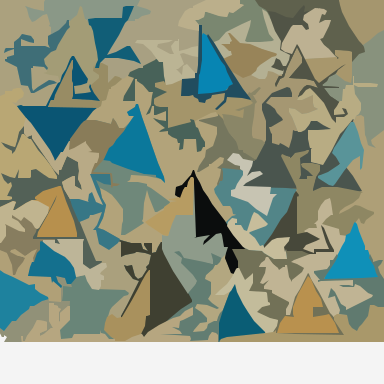

In [ ]:
from IPython.display import SVG, display

display(SVG(svg_str))


In [60]:
with open("output.svg", "w", encoding="utf-8") as f:
    f.write(svg_str)

In [48]:
import xml.etree.ElementTree as ET
import cv2
import numpy as np
from io import BytesIO
from PIL import Image
import vtracer
import re
from itertools import product


default_svg = """
        <svg xmlns="http://www.w3.org/2000/svg" width="384" height="384"><rect width="100%" height="100%"/>
        <path d="M218 333v-3m-5-6c6-2 5 4 5 4m0 0s-6-2-6 2c1 5 6 0 6 0m0-2v2M221 324l4 9m0 0 3-9m-3 9-4 4M128.5 341.5l2.5 8.5 3-7.5 3.5 7.5 2.5-8.5M196 338v14M153.5 351v-7m0-7v7m0 0s7-7.5 6.5 7"/>
        <path id="h" d="M180.5 342v6.5m0 2.5v-2.5m0 0s-7.5 7.5-6.5-7"/><use x="64" y="18" href="#h" transform="rotate(180 241 364)"/>
        <path d="M143 342v9m0-11v-2M131 369v-11l8 11v-12M173 369l3-5m4-4-4 4m0 0-3-4m3 4 3 5M239.5 331l-1 4M246.5 349l-1 4"/>
        </svg>"""


def parse_svg_path_d(d_str):
    import re

    commands = re.findall(r"[MLZmlz]|-?\d*\.?\d+", d_str)
    points = []
    i = 0
    while i < len(commands):
        cmd = commands[i]
        if cmd.upper() in ["M", "L"]:
            x = float(commands[i + 1])
            y = float(commands[i + 2])
            points.append([x, y])
            i += 3
        else:
            i += 1
    return np.array(points, dtype=np.float32)


def simplify_polygon(points, epsilon):
    return cv2.approxPolyDP(points, epsilon, closed=False).reshape(-1, 2)


def points_to_svg_path(points):
    if len(points) == 0:
        return ""
    d = f"M{points[0][0]},{points[0][1]} "
    for pt in points[1:]:
        d += f"L{pt[0]},{pt[1]} "
    return d.strip()


def simplify_svg_file(svg_str, epsilon=1.0) -> str:
    def simplify_path_d(match):
        original_d = match.group(1)
        try:
            points = parse_svg_path_d(original_d)
            if len(points) < 2:
                return f'd="{original_d}"'
            simplified = simplify_polygon(points, epsilon)
            new_d = points_to_svg_path(simplified)
            return f'd="{new_d}"'
        except Exception as e:
            print(f"⚠️ Lỗi xử lý path: {e}")
            return f'd="{original_d}"'

    # Tìm và xử lý các thuộc tính d="...":
    simplified_svg = re.sub(r'd="([^"]+)"', simplify_path_d, svg_str)

    # Đảm bảo có </svg> ở cuối
    if not simplified_svg.strip().endswith("</svg>"):
        simplified_svg += "\n</svg>"

    print(
        f"📦 Dung lượng sau khi đơn giản hóa: {len(simplified_svg.encode('utf-8'))} bytes"
    )
    return simplified_svg


def remove_version_attribute(svg_str: str) -> str:
    ET.register_namespace("", "http://www.w3.org/2000/svg")
    tree = ET.ElementTree(ET.fromstring(svg_str))
    root = tree.getroot()

    if "version" in root.attrib:
        del root.attrib["version"]

    output = BytesIO()
    tree.write(output, encoding="utf-8", xml_declaration=True)
    return output.getvalue().decode("utf-8")


def find_best_epsilon(svg_str, target_min=9700, target_max=9800, max_iter=20):
    low = 0.1
    high = 10.0
    best_epsilon = None
    best_svg = default_svg
    best_size = float("inf")

    for _ in range(max_iter):
        mid = (low + high) / 2
        simplified_svg = simplify_svg_file(svg_str, epsilon=mid)
        simplified_svg = remove_version_attribute(simplified_svg)
        size = len(simplified_svg.encode("utf-8"))

        if target_min <= size <= target_max:
            best_epsilon = mid
            best_svg = simplified_svg
            best_size = size
            low = mid  # thử tăng epsilon tiếp để đơn giản hóa hơn
        elif size > target_max:
            low = mid  # quá lớn → tăng epsilon
        else:
            high = mid  # quá nhỏ → giảm epsilon

    return best_epsilon, best_size, best_svg


def add_ocr_decoy_svg(svg_code: str) -> str:
    """
    Adds nested circles with second darkest and second brightest colors from the existing SVG,
    positioned in one of the four corners (randomly selected) but positioned to avoid being
    cropped out during image processing.

    Parameters:
    -----------
    svg_code : str
        The original SVG string

    Returns:
    --------
    str
        Modified SVG with the nested circles added
    """
    import random
    import re
    from colorsys import rgb_to_hls, hls_to_rgb

    # Check if SVG has a closing tag
    if "</svg>" not in svg_code:
        return svg_code

    # Extract viewBox if it exists to understand the dimensions
    viewbox_match = re.search(r'viewBox=["\'](.*?)["\']', svg_code)
    if viewbox_match:
        viewbox = viewbox_match.group(1).split()
        try:
            x, y, width, height = map(float, viewbox)
        except ValueError:
            # Default dimensions if we can't parse viewBox
            width, height = 384, 384
    else:
        # Default dimensions if viewBox not found
        width, height = 384, 384

    # Function to convert hex color to RGB
    def hex_to_rgb(hex_color):
        hex_color = hex_color.lstrip("#")
        if len(hex_color) == 3:
            hex_color = "".join([c * 2 for c in hex_color])
        return tuple(int(hex_color[i : i + 2], 16) / 255 for i in (0, 2, 4))

    # Function to convert RGB to hex
    def rgb_to_hex(rgb):
        return "#{:02x}{:02x}{:02x}".format(
            int(rgb[0] * 255), int(rgb[1] * 255), int(rgb[2] * 255)
        )

    # Function to calculate color lightness
    def get_lightness(color):
        # Handle different color formats
        if color.startswith("#"):
            rgb = hex_to_rgb(color)
            return rgb_to_hls(*rgb)[1]  # Lightness is the second value in HLS
        elif color.startswith("rgb"):
            rgb_match = re.search(r"rgb\((\d+),\s*(\d+),\s*(\d+)\)", color)
            if rgb_match:
                r, g, b = map(lambda x: int(x) / 255, rgb_match.groups())
                return rgb_to_hls(r, g, b)[1]
        return 0.5  # Default lightness if we can't parse

    # Extract all colors from the SVG
    color_matches = re.findall(
        r'(?:fill|stroke)="(#[0-9A-Fa-f]{3,6}|rgb\(\d+,\s*\d+,\s*\d+\))"', svg_code
    )

    # Default colors in case we don't find enough
    second_darkest_color = "#333333"  # Default to dark gray
    second_brightest_color = "#CCCCCC"  # Default to light gray

    if color_matches:
        # Remove duplicates and get unique colors
        unique_colors = list(set(color_matches))

        # Calculate lightness for each unique color
        colors_with_lightness = [
            (color, get_lightness(color)) for color in unique_colors
        ]

        # Sort by lightness (brightness)
        sorted_colors = sorted(colors_with_lightness, key=lambda x: x[1])

        # Handle different scenarios based on number of unique colors
        if len(sorted_colors) >= 4:
            # We have at least 4 unique colors - use 2nd darkest and 2nd brightest
            second_darkest_color = sorted_colors[1][0]
            second_brightest_color = sorted_colors[-2][0]
        elif len(sorted_colors) == 3:
            # We have 3 unique colors - use 2nd darkest and brightest
            second_darkest_color = sorted_colors[1][0]
            second_brightest_color = sorted_colors[2][0]
        elif len(sorted_colors) == 2:
            # We have only 2 unique colors - use the darkest and brightest
            second_darkest_color = sorted_colors[0][0]
            second_brightest_color = sorted_colors[1][0]
        elif len(sorted_colors) == 1:
            # Only one color - use it for second_darkest and a derived lighter version
            base_color = sorted_colors[0][0]
            base_lightness = sorted_colors[0][1]
            second_darkest_color = base_color

            # Create a lighter color variant if the base is dark, or darker if base is light
            if base_lightness < 0.5:
                # Base is dark, create lighter variant
                second_brightest_color = "#CCCCCC"
            else:
                # Base is light, create darker variant
                second_darkest_color = "#333333"

    # Ensure the colors are different
    if second_darkest_color == second_brightest_color:
        # If they ended up the same, modify one of them
        if get_lightness(second_darkest_color) < 0.5:
            # It's a dark color, make the bright one lighter
            second_brightest_color = "#CCCCCC"
        else:
            # It's a light color, make the dark one darker
            second_darkest_color = "#333333"

    # Base size for the outer circle
    base_outer_radius = width * 0.023

    # Randomize size by ±10%
    size_variation = base_outer_radius * 0.1
    outer_radius = base_outer_radius + random.uniform(-size_variation, size_variation)

    # Define radii for inner circles based on outer radius
    middle_radius = outer_radius * 0.80
    inner_radius = middle_radius * 0.65

    # Calculate the maximum crop margin based on the image processing (5% of dimensions)
    # Add 20% extra margin for safety
    crop_margin_w = int(width * 0.05 * 1.2)
    crop_margin_h = int(height * 0.05 * 1.2)

    # Calculate center point based on the outer radius to ensure the entire circle stays visible
    safe_offset = outer_radius + max(crop_margin_w, crop_margin_h)

    # Choose a random corner (0: top-left, 1: top-right, 2: bottom-left, 3: bottom-right)
    corner = random.randint(0, 3)

    # Position the circle in the chosen corner, accounting for crop margin
    if corner == 0:  # Top-left
        center_x = safe_offset
        center_y = safe_offset
    elif corner == 1:  # Top-right
        center_x = width - safe_offset
        center_y = safe_offset
    elif corner == 2:  # Bottom-left
        center_x = safe_offset
        center_y = height - safe_offset
    else:  # Bottom-right
        center_x = width - safe_offset
        center_y = height - safe_offset

    # Add a small random offset (±10% of safe_offset) to make positioning less predictable
    random_offset = safe_offset * 0.1
    center_x += random.uniform(-random_offset, random_offset)
    center_y += random.uniform(-random_offset, random_offset)

    # Round to 1 decimal place to keep file size down
    outer_radius = round(outer_radius, 1)
    middle_radius = round(middle_radius, 1)
    inner_radius = round(inner_radius, 1)
    center_x = round(center_x, 1)
    center_y = round(center_y, 1)

    # Create the nested circles
    outer_circle = f'<circle cx="{center_x}" cy="{center_y}" r="{outer_radius}" fill="{second_darkest_color}" />'
    middle_circle = f'<circle cx="{center_x}" cy="{center_y}" r="{middle_radius}" fill="{second_brightest_color}" />'
    inner_circle = f'<circle cx="{center_x}" cy="{center_y}" r="{inner_radius}" fill="{second_darkest_color}" />'

    # Create a group element that contains all three circles
    group_element = f"<g>{outer_circle}{middle_circle}{inner_circle}</g>"

    # Insert the group element just before the closing SVG tag
    modified_svg = svg_code.replace("</svg>", f"{group_element}</svg>")

    # Calculate and add a comment with the byte size information
    outer_bytes = len(outer_circle.encode("utf-8"))
    middle_bytes = len(middle_circle.encode("utf-8"))
    inner_bytes = len(inner_circle.encode("utf-8"))
    total_bytes = outer_bytes + middle_bytes + inner_bytes

    corner_names = ["top-left", "top-right", "bottom-left", "bottom-right"]
    byte_info = (
        f"<!-- Circle bytes: outer={outer_bytes}, middle={middle_bytes}, "
        f"inner={inner_bytes}, total={total_bytes}, "
        f"colors: dark={second_darkest_color}, light={second_brightest_color}, "
        f"position: {corner_names[corner]} -->"
    )

    # modified_svg = modified_svg.replace("</svg>", f"{byte_info}</svg>")

    return modified_svg


def image_to_svg(image: Image, max_size: int = 9800) -> str:
    image = image.convert("RGBA")
    resized_img = image.resize((384, 384), Image.Resampling.LANCZOS)
    pixels = list(resized_img.getdata())

    speckle_values = [4, 10, 20]
    layer_diff_values = [16]
    color_precision_values = [4, 5, 6]

    best_svg = None
    best_params = {}
    best_size = 0  # theo dõi kích thước tốt nhất nhỏ hơn max_size

    for filter_speckle, layer_difference, color_precision in product(speckle_values, layer_diff_values, color_precision_values):
        svg_str = vtracer.convert_pixels_to_svg(
            rgba_pixels=pixels,
            size=resized_img.size,
            colormode="color",        # ["color"] or "binary"
            hierarchical="stacked",     # ["stacked"] or "cutout"
            mode="polygon",             # ["spline"], "polygon", "none"
            filter_speckle=filter_speckle,   # default: 4
            color_precision=color_precision,  # default: 6
            layer_difference=layer_difference, # default: 16
            corner_threshold=60, # default: 60   
            length_threshold=4.0, # in [3.5, 10] default: 4.0
            max_iterations=10,   # default: 10
            splice_threshold=45, # default: 45
            path_precision=1,   # default: 8
        )

        byte_len = len(svg_str.encode("utf-8"))
        if byte_len <= max_size and byte_len > best_size:
            best_svg = svg_str
            best_params = {
                "filter_speckle": filter_speckle,
                "layer_difference": layer_difference,
                "color_precision": color_precision
            }
            best_size = byte_len

    if best_svg:
        modified_svg = add_ocr_decoy_svg(best_svg)
        return modified_svg, best_params, best_size
    else:
        return default_svg, 1, 1



580
1
1


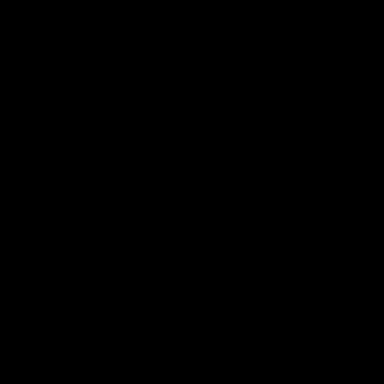

In [49]:

if __name__ == "__main__":
    image = Image.open(
        "/home/anhndt/draw_with_llms/data/results/version_4_sdxl_turbo_15--unknown_processing/1e9ac1-a lighthouse overlooking the ocean/raw - 0 - 0.5829.png"
    )
    svg, best_params,  best_size = image_to_svg(image)

    print(len(svg.encode('utf-8')))
    print(best_params)
    print(best_size)
    display(SVG(svg))

In [17]:
from IPython.display import SVG, display

with open("/home/anhndt/draw_with_llms/notebooks/export-2025-05-20 050210.svg", "r", encoding="utf-8") as f:
    svg_str = f.read()

print(len(svg_str.encode('utf-8')))
# display(SVG(svg_str))



9241


In [78]:
import xml.etree.ElementTree as ET
import cv2
from scour import scour

import numpy as np
from io import BytesIO
from PIL import Image
import vtracer
import re
from itertools import product


default_svg = """<svg width="256" height="256" viewBox="0 0 256 256"><circle cx="50" cy="50" r="40" fill="red" /></svg>"""


def remove_version_attribute(svg_str: str) -> str:
    ET.register_namespace("", "http://www.w3.org/2000/svg")
    tree = ET.ElementTree(ET.fromstring(svg_str))
    root = tree.getroot()

    if "version" in root.attrib:
        del root.attrib["version"]

    output = BytesIO()
    tree.write(output, encoding="utf-8", xml_declaration=True)
    return output.getvalue().decode("utf-8")


def add_ocr_decoy_svg(svg_code: str) -> str:
    """
    Adds nested circles with second darkest and second brightest colors from the existing SVG,
    positioned in one of the four corners (randomly selected) but positioned to avoid being
    cropped out during image processing.

    Parameters:
    -----------
    svg_code : str
        The original SVG string

    Returns:
    --------
    str
        Modified SVG with the nested circles added
    """
    import random
    import re
    from colorsys import rgb_to_hls, hls_to_rgb

    # Check if SVG has a closing tag
    if "</svg>" not in svg_code:
        return svg_code

    # Extract viewBox if it exists to understand the dimensions
    viewbox_match = re.search(r'viewBox=["\'](.*?)["\']', svg_code)
    if viewbox_match:
        viewbox = viewbox_match.group(1).split()
        try:
            x, y, width, height = map(float, viewbox)
        except ValueError:
            # Default dimensions if we can't parse viewBox
            width, height = 384, 384
    else:
        # Default dimensions if viewBox not found
        width, height = 384, 384

    # Function to convert hex color to RGB
    def hex_to_rgb(hex_color):
        hex_color = hex_color.lstrip("#")
        if len(hex_color) == 3:
            hex_color = "".join([c * 2 for c in hex_color])
        return tuple(int(hex_color[i: i + 2], 16) / 255 for i in (0, 2, 4))

    # Function to convert RGB to hex
    def rgb_to_hex(rgb):
        return "#{:02x}{:02x}{:02x}".format(
            int(rgb[0] * 255), int(rgb[1] * 255), int(rgb[2] * 255)
        )

    # Function to calculate color lightness
    def get_lightness(color):
        # Handle different color formats
        if color.startswith("#"):
            rgb = hex_to_rgb(color)
            return rgb_to_hls(*rgb)[1]  # Lightness is the second value in HLS
        elif color.startswith("rgb"):
            rgb_match = re.search(r"rgb\((\d+),\s*(\d+),\s*(\d+)\)", color)
            if rgb_match:
                r, g, b = map(lambda x: int(x) / 255, rgb_match.groups())
                return rgb_to_hls(r, g, b)[1]
        return 0.5  # Default lightness if we can't parse

    # Extract all colors from the SVG
    color_matches = re.findall(
        r'(?:fill|stroke)="(#[0-9A-Fa-f]{3,6}|rgb\(\d+,\s*\d+,\s*\d+\))"', svg_code
    )

    # Default colors in case we don't find enough
    second_darkest_color = "#333333"  # Default to dark gray
    second_brightest_color = "#CCCCCC"  # Default to light gray

    if color_matches:
        # Remove duplicates and get unique colors
        unique_colors = list(set(color_matches))

        # Calculate lightness for each unique color
        colors_with_lightness = [
            (color, get_lightness(color)) for color in unique_colors
        ]

        # Sort by lightness (brightness)
        sorted_colors = sorted(colors_with_lightness, key=lambda x: x[1])

        # Handle different scenarios based on number of unique colors
        if len(sorted_colors) >= 4:
            # We have at least 4 unique colors - use 2nd darkest and 2nd brightest
            second_darkest_color = sorted_colors[1][0]
            second_brightest_color = sorted_colors[-2][0]
        elif len(sorted_colors) == 3:
            # We have 3 unique colors - use 2nd darkest and brightest
            second_darkest_color = sorted_colors[1][0]
            second_brightest_color = sorted_colors[2][0]
        elif len(sorted_colors) == 2:
            # We have only 2 unique colors - use the darkest and brightest
            second_darkest_color = sorted_colors[0][0]
            second_brightest_color = sorted_colors[1][0]
        elif len(sorted_colors) == 1:
            # Only one color - use it for second_darkest and a derived lighter version
            base_color = sorted_colors[0][0]
            base_lightness = sorted_colors[0][1]
            second_darkest_color = base_color

            # Create a lighter color variant if the base is dark, or darker if base is light
            if base_lightness < 0.5:
                # Base is dark, create lighter variant
                second_brightest_color = "#CCCCCC"
            else:
                # Base is light, create darker variant
                second_darkest_color = "#333333"

    # Ensure the colors are different
    if second_darkest_color == second_brightest_color:
        # If they ended up the same, modify one of them
        if get_lightness(second_darkest_color) < 0.5:
            # It's a dark color, make the bright one lighter
            second_brightest_color = "#CCCCCC"
        else:
            # It's a light color, make the dark one darker
            second_darkest_color = "#333333"

    # Base size for the outer circle
    base_outer_radius = width * 0.023

    # Randomize size by ±10%
    size_variation = base_outer_radius * 0.1
    outer_radius = base_outer_radius + \
        random.uniform(-size_variation, size_variation)

    # Define radii for inner circles based on outer radius
    middle_radius = outer_radius * 0.80
    inner_radius = middle_radius * 0.65

    # Calculate the maximum crop margin based on the image processing (5% of dimensions)
    # Add 20% extra margin for safety
    crop_margin_w = int(width * 0.05 * 1.2)
    crop_margin_h = int(height * 0.05 * 1.2)

    # Calculate center point based on the outer radius to ensure the entire circle stays visible
    safe_offset = outer_radius + max(crop_margin_w, crop_margin_h)

    # Choose a random corner (0: top-left, 1: top-right, 2: bottom-left, 3: bottom-right)
    corner = random.randint(0, 3)

    # Position the circle in the chosen corner, accounting for crop margin
    if corner == 0:  # Top-left
        center_x = safe_offset
        center_y = safe_offset
    elif corner == 1:  # Top-right
        center_x = width - safe_offset
        center_y = safe_offset
    elif corner == 2:  # Bottom-left
        center_x = safe_offset
        center_y = height - safe_offset
    else:  # Bottom-right
        center_x = width - safe_offset
        center_y = height - safe_offset

    # Add a small random offset (±10% of safe_offset) to make positioning less predictable
    random_offset = safe_offset * 0.1
    center_x += random.uniform(-random_offset, random_offset)
    center_y += random.uniform(-random_offset, random_offset)

    # Round to 1 decimal place to keep file size down
    outer_radius = round(outer_radius, 1)
    middle_radius = round(middle_radius, 1)
    inner_radius = round(inner_radius, 1)
    center_x = round(center_x, 1)
    center_y = round(center_y, 1)

    # Create the nested circles
    outer_circle = f'<circle cx="{center_x}" cy="{center_y}" r="{outer_radius}" fill="{second_darkest_color}" />'
    middle_circle = f'<circle cx="{center_x}" cy="{center_y}" r="{middle_radius}" fill="{second_brightest_color}" />'
    inner_circle = f'<circle cx="{center_x}" cy="{center_y}" r="{inner_radius}" fill="{second_darkest_color}" />'

    # Create a group element that contains all three circles
    group_element = f"<g>{outer_circle}{middle_circle}{inner_circle}</g>"

    # Insert the group element just before the closing SVG tag
    modified_svg = svg_code.replace("</svg>", f"{group_element}</svg>")

    # Calculate and add a comment with the byte size information
    outer_bytes = len(outer_circle.encode("utf-8"))
    middle_bytes = len(middle_circle.encode("utf-8"))
    inner_bytes = len(inner_circle.encode("utf-8"))
    total_bytes = outer_bytes + middle_bytes + inner_bytes

    corner_names = ["top-left", "top-right", "bottom-left", "bottom-right"]
    byte_info = (
        f"<!-- Circle bytes: outer={outer_bytes}, middle={middle_bytes}, "
        f"inner={inner_bytes}, total={total_bytes}, "
        f"colors: dark={second_darkest_color}, light={second_brightest_color}, "
        f"position: {corner_names[corner]} -->"
    )

    # modified_svg = modified_svg.replace("</svg>", f"{byte_info}</svg>")

    return modified_svg


def image_to_svg(image: Image, max_size: int = 9800) -> str:
    image = image.convert("RGBA")
    resized_img = image.resize((384, 384), Image.Resampling.LANCZOS)
    pixels = list(resized_img.getdata())

    speckle_values = [10, 40, 60]
    layer_diff_values = [64, 124]
    color_precision_values = [4, 6, 8]

    best_svg = None
    best_params = {}
    best_size = 0  # theo dõi kích thước tốt nhất nhỏ hơn max_size

    for filter_speckle, layer_difference, color_precision in product(speckle_values, layer_diff_values, color_precision_values):
        svg_str = vtracer.convert_pixels_to_svg(
            rgba_pixels=pixels,
            size=resized_img.size,
            colormode="color",        # ["color"] or "binary"
            hierarchical="stacked",     # ["stacked"] or "cutout"
            mode="polygon",             # ["spline"], "polygon", "none"
            filter_speckle=filter_speckle,   # default: 4
            color_precision=color_precision,  # default: 6
            layer_difference=layer_difference,  # default: 16
            corner_threshold=60,  # default: 60
            length_threshold=4.0,  # in [3.5, 10] default: 4.0
            max_iterations=1,   # default: 10
            splice_threshold=45,  # default: 45
            path_precision=8,   # default: 8
        )

        options = scour.sanitizeOptions({
            'enable-comment-stripping': True,
            'remove-metadata': True,
            'remove-descriptions': True,
            'set-precision': 0,
            'remove-descriptive-elements': True,
            'strip-xml-prolog': True,
            'disable-style_to-xml': True
        })

        add_o = add_ocr_decoy_svg(svg_str)
        optimized_svg = scour.scourString(add_o, options)
        byte_len = len(optimized_svg.encode("utf-8"))
        
        if byte_len <= max_size and byte_len > best_size:
            best_svg = remove_version_attribute(optimized_svg)
            best_svg = re.sub(r"<\?xml[^>]+\?>\s*", "", best_svg)
            best_params = {
                "filter_speckle": filter_speckle,
                "layer_difference": layer_difference,
                "color_precision": color_precision
            }
            best_size = byte_len
    print(f"{best_params}")

    if best_svg:
        return best_svg
    else:
        return default_svg


In [76]:
input = "/home/anhndt/draw_with_llms/data/results/version_5_sdxl_turbo_15--unknown_processing/ad4c5c-a starlit night over snow-covered peaks/raw - 2 - 0.7226.png"

{'filter_speckle': 40, 'layer_difference': 64, 'color_precision': 6}
9223


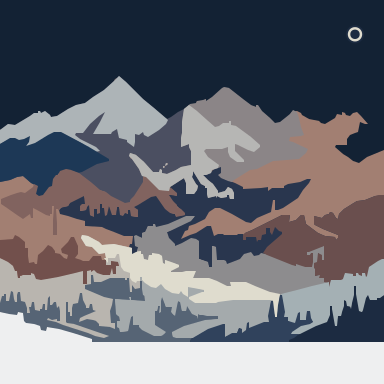

In [77]:
from IPython.display import SVG, display

img = Image.open(input)
svg_str = image_to_svg(img, 10000)
print(len(svg_str.encode('utf-8')))
display(SVG(svg_str))

{'filter_speckle': 10, 'layer_difference': 124, 'color_precision': 4}
9846


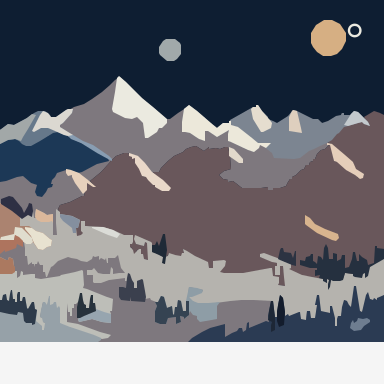

In [68]:
from IPython.display import SVG, display

img = Image.open(input)
svg_str = image_to_svg(img, 10000)
print(len(svg_str.encode('utf-8')))
display(SVG(svg_str))

In [56]:
svg_str

'<svg xmlns="http://www.w3.org/2000/svg" width="384" height="384">\n <path transform="translate(0)" d="m0 0h384v384h-384z" fill="#A27F72" />\n <path transform="translate(186,216)" d="m0 0h9l-4 5-21 10-3 1 2 6 6 6v2l7-3 9-5 5 1 3 2v18l9 3 1 5h3v-21l4 1 1 13h7l2 1 1 3 13-5 4-5 7-2 3 4 5-1 2-2 9 2 12 5 10 4 4 2v-2l8 1 1 1 7 1 1-14h-2l-1 3-3-1v-3l11-5 6-1v14h-2l-2-6-2-1v9l-2 2-2-1v5l3 1h-2v7l5-1v2l4 1 1 4h4v5l2-7h10l2-1 2-6 8 1v2h3v-3h2l1 2 3 1v-3h3l1 4 1-1 2-9 9-6 6-2v125h-384v-126l5 2 6 3 4 4v4h2l1 7h2v-2h2l1-4v3h8v-2l4 1 1 4 5 1 23-4 13-4h6v13h4l-1-13 5-1 3-2v2l3 1 1 2 5 1h7l1-7 2 1v6h3v-8h3l-1-3-7-2v4h-5v-6l-2-1h2l-1-5-6 1-7-7-6-1-5-8 1-3 6 1 11 6 3 3 12-1 18 4v6l4-2 2-5-3-1-1-10 2-1 6 3v-5l3-1 3-6h5v-2h2l1 3 12-3z" fill="#B9B5AF" />\n <path transform="translate(0)" d="m0 0h384v150l-17 7-8 6-6-2-5-4-5-3-8-7 1-2h11v-6l3-4 5-2 3-1 2-10 5 2h3l-7-8-4-4-4 1-3 3-4-1-1-2-3-1v3l-5-1-2 4-10 6-4-1-2-2-10-2-7-4-1-2-4-2-5 1-5 6-9 6-4-1-5-5-8-7-3-4v-2h-2v2l-5-1-18-14-5-4-6 1-7 7-7 5h-2v-2l-5 3-4-1-